In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from utils.config import load_config_nb

# Configuration for plotting and warnings
sns.set(context='notebook', font_scale=1.1, 
        style='ticks', rc={'figure.figsize': (8, 3), 'figure.facecolor': 'none', 'axes.facecolor': 'none'})
plt.set_loglevel('WARNING')
plt.rcParams.update({'lines.markeredgewidth': 1})
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'svg'

### Configurations

In [4]:
# Trained models
models_config = load_config_nb('models_main_paper') 

# Environment configurations
env_config = load_config_nb('env_config')

MAPPING = {
    np.nan: "BC",
    0.0: "PPO",
    0.02: "HR-PPO (λ = 0.02)",
    0.06: "HR-PPO (λ = 0.06)",
    0.07: "HR-PPO (λ = 0.07)",
    0.08: "HR-PPO (λ = 0.08)",
}

AGENT_MAP = {
    'MA HR-PPO': 'HR-PPO',
}

def mean_perc(ser: pd.Series) -> float:
    return ser.mean() * 100

def mean_plus_binary_se(ser: pd.Series, scale: float = 100, n:int = 2000) -> str:
    """Compute the mean and standard error for binary outcomes."""
    p_metric = ser.mean()
    se_binary = np.sqrt(p_metric * (1 - p_metric) / n)
    return f"{p_metric*scale:.2f} ± {se_binary*scale:.2f}"        
        
def calculate_std(row):
    """Comput the standard deviation for binary outcomes."""
    for column in ['goal_rate', 'off_road', 'veh_veh_collision']:
        p = row[column] / 100
        row[f'{column}_std'] = np.sqrt(p * (1 - p))
    return row

def calculate_se(row, n=2000):
    """Comput the standard error for binary outcomes."""
    for column in ['goal_rate', 'off_road', 'veh_veh_collision']:
        p = row[column] / 100
        row[f'{column}_se'] = np.sqrt((p * (1 - p)) / n)
    return row

INT_BINS = [-1, 0, 1, 2, float('inf')]
INT_LABELS = ['0', '1', '2', '3+']

STEP_BINS = [0, 10, 20, 30, 40, float('inf')]
STEP_LABELS = ['0-1 s', '1-2 s', '2-3 s', '3-4 s', '4+ s']


TOT_INT_BINS = [-1, 2, 4, 6, 8, float('inf')]
TOT_INT_LABELS = ['0', '2', '4',  '6', '8+']

# Path to save videos
VIDEO_PATH = "../evaluation/videos"

### Load dataset

In [7]:
# Dataframe with the results
path = '../evaluation/results/df_paper_agg_performance_03_07_14_02_200train_scenes_10_000_test_final.csv'

df = pd.read_csv(path)

df['Reg. weight'] = df['Reg. weight'].replace(MAPPING)
df['Agent'] = df["Reg. weight"].replace(AGENT_MAP)
df['int_path_cat'] = pd.cut(df['veh_int_paths'], bins=INT_BINS, labels=INT_LABELS, include_lowest=True)
df['step_diff_cat'] = pd.cut(df['min_step_diff'], bins=STEP_BINS, labels=STEP_LABELS, include_lowest=True)
df['int_path_cat_tot'] = pd.cut(df['tot_int_paths'], bins=TOT_INT_BINS, labels=TOT_INT_LABELS, include_lowest=True)

### Helper functions

In [8]:
def plot_eval_mode_bar(df, save=True, fig_name='self_play_log_replay_comp', 
                       x_axis_order=['Self-play', 'Log-replay'], 
                       colors=['b', 'darkorange', 'tab:purple'], alpha=0.5
                    ):
    """Plot the overall effectiveness of agents across evaluation modes."""
    
    #df['Agent'].replace(to_replace=r'HR-PPO \| λ = [\d.]+', value='HR-PPO', regex=True, inplace=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    sns.barplot(data=df, x='Eval mode', y='veh_veh_collision', hue='Agent', errorbar='sd', palette=colors, order=x_axis_order, ax=axs[1], legend=False);
    axs[1].grid(True, alpha=alpha)
    axs[1].set_xlabel('Evaluation mode', labelpad=10, fontsize=10)
    axs[1].set_ylabel('Collision rate [%]')

    sns.barplot(data=df, x='Eval mode', y='goal_rate', hue='Agent', errorbar='sd', palette=colors, order=x_axis_order, ax=axs[0], legend=False);
    axs[0].grid(True, alpha=alpha)
    axs[0].set_xlabel('Evaluation mode', labelpad=10, fontsize=10)
    axs[0].set_ylabel('Goal rate [%]')

    sns.barplot(data=df, x='Eval mode', y='off_road', hue='Agent', errorbar='sd', palette=colors, order=x_axis_order, ax=axs[2], legend=True);
    axs[2].grid(True, alpha=alpha)
    axs[2].set_xlabel('Evaluation mode', labelpad=10, fontsize=10)
    axs[2].set_ylabel('Off-Road [%]')
    
    axs[0].set_ylim([0, 100])

    axs[2].legend(loc='upper left', title='Agent', fontsize=12, bbox_to_anchor=(1, 1))

    plt.tight_layout()
    sns.despine()
    
    if save:
        plt.savefig(f'../evaluation/figures/coordination/{fig_name}.pdf', bbox_inches="tight")
        
        
def plot_collision_interactivity(
    df_self_play, 
    df_log_replay, 
    coll_diffs, 
    x_metric, 
    save=True, 
    fig_name='collision_interactivity', 
    colors=['tab:purple', 'darkorange', 'b']
    ):
    """Plot the collision rate as a function of the intersecting paths."""
    
    coll_diffs['Agent'].replace(to_replace=r'HR-PPO \| λ = [\d.]+', value='HR-PPO', regex=True, inplace=True)   
    
    # Multiply the 'veh_veh_collision' values by 100
    df_self_play['veh_veh_collision'] *= 100
    df_log_replay['veh_veh_collision'] *= 100
    coll_diffs['diffs'] *= 100
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=False, sharex=False)

    sns.lineplot(
        x=x_metric, 
        y='veh_veh_collision', 
        data=df_self_play, 
        palette=colors,
        hue='Agent',
        err_style='bars',  
        linewidth=2,
        markers=True, 
        errorbar='se',   
        ax=axs[0],
        legend=False
    )
    axs[0].set_title('Self-play')
    axs[0].set_ylim([0, 70])
    axs[0].grid(True, alpha=0.5)
    axs[0].set_xlabel('Number of intersecting paths', labelpad=10)
    axs[0].set_ylabel('Collision rate [%]')

    sns.lineplot(
        x=x_metric, 
        y='veh_veh_collision', 
        data=df_log_replay, 
        hue='Agent',
        palette=colors,
        err_style='bars',  
        linewidth=2,
        markers=True, 
        errorbar='se',    
        ax=axs[1],
        legend=False,
    );

    axs[1].set_title('Log-replay')
    axs[1].grid(True, alpha=0.5)
    axs[1].set_ylim([0, 70])
    axs[1].set_xlabel('Number of intersecting paths', labelpad=10)
    axs[1].set_ylabel('Collision rate [%]')
    
    sns.barplot(
        x=x_metric, 
        y='diffs', 
        data=coll_diffs, 
        hue='Agent',
        hue_order=['PPO', 'HR-PPO (λ = 0.07)', 'BC'],
        palette=colors,
        linewidth=2,
        ax=axs[2],
        legend=False,
    );

    axs[2].set_title('Increase in collision rate \n when switching to log-replay')
    axs[2].grid(True, alpha=0.5)
    axs[2].set_ylim([0, 70])
    axs[2].set_xlabel('Number of intersecting paths', labelpad=10)
    axs[2].set_ylabel('∆ Collision rate [%]')
    axs[0].legend(loc='upper left', title='Agent', labels=['PPO', 'HR-PPO', 'BC'], facecolor='white', fontsize=12)#, bbox_to_anchor=, 1))

    plt.tight_layout()
    sns.despine()
    
    if save:
        plt.savefig(f'../evaluation/figures/coordination/{fig_name}.pdf', bbox_inches="tight")

### **Overall performance** self-play vs. log-replay across datasets

- Select best HR-PPO agent
- Select best PPO agent

In [9]:
df_select_top = df[df['Reg. weight'].isin(['BC', 'PPO', 'HR-PPO (λ = 0.06)'])]

df_agg_perf = df_select_top.pivot_table(
    index=['Agent', 'Train agent', 'Dataset', 'Eval mode'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'],
    aggfunc=mean_perc, # Use for table: mean_plus_binary_se
)

In [10]:
#print((df_agg_perf.style.format(precision=2)).to_latex())

In [11]:
df_agg_perf = df_agg_perf.reset_index()

### Bar plots

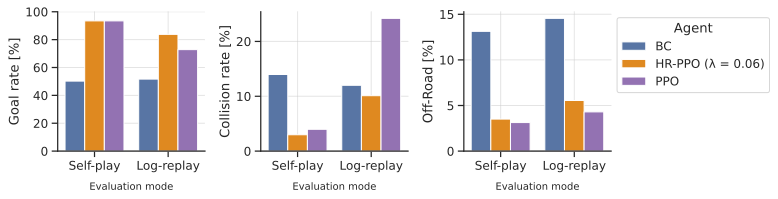

In [13]:
df_agg_perf_train = df_agg_perf[(df_agg_perf['Dataset'] == 'Train') & ((df_agg_perf['Train agent'] != 'Log-replay'))]

plot_eval_mode_bar(df_agg_perf_train, save=True, fig_name='train_eval_mode_bar')

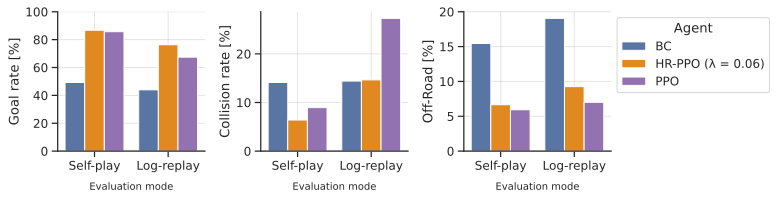

In [14]:
df_agg_perf_test = df_agg_perf[(df_agg_perf['Dataset'] == 'Test') & ((df_agg_perf['Train agent'] != 'Log-replay'))]

plot_eval_mode_bar(df_agg_perf_test, save=True, fig_name='test_eval_mode_bar')

### **Interactivity**

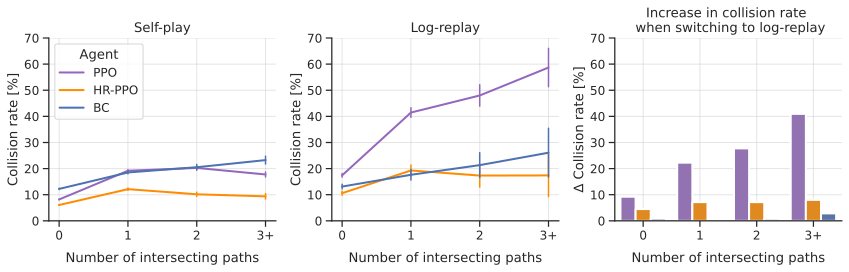

In [15]:
METRIC = 'int_path_cat'

df_select_top = df[df['Agent'].isin(['PPO', 'BC', 'HR-PPO (λ = 0.07)'])]
df_select_top = df_select_top[df_select_top['Dataset'] == 'Test']
df_select_top['Agent'].replace(to_replace='HR-PPO (λ = 0.07)', value='HR-PPO', regex=True, inplace=True)   

df_select_top_sp = df_select_top[df_select_top['Eval mode'] == 'Self-play']
df_select_top_lr = df_select_top[df_select_top['Eval mode'] == 'Log-replay']

int_path_sp = df_select_top_sp.groupby(['Agent', METRIC]).agg({'veh_veh_collision': 'mean'}).reset_index()
coll_diffs = df_select_top_lr.groupby(['Agent', METRIC]).agg({'veh_veh_collision': 'mean'}).reset_index()

coll_diffs['diffs'] = coll_diffs['veh_veh_collision'] - int_path_sp['veh_veh_collision']

plot_collision_interactivity(df_select_top_sp, df_select_top_lr, coll_diffs, METRIC, save=True, fig_name='collision_interactivity_test_10k')